In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path


import sys
sys.path.append("..")

from src.data_preprocessor import FraudDataPreprocessor


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Load data

In [13]:
preprocessor = FraudDataPreprocessor()
fraud_df, ip_map_df, _ = preprocessor.load_data(
    'D:/kifiya AI/fraud-detection/data/raw/Fraud_Data.csv',
    'D:/kifiya AI/fraud-detection/data/raw/IpAddress_to_Country.csv',
    'D:/kifiya AI/fraud-detection/data/raw/creditcard.csv'  # Dummy path
)

print("=== EDA for Fraud Data ===")
print(f"Shape: {fraud_df.shape}")
print("\nFirst few rows:")
print(fraud_df.head())

2025-12-19 02:36:34,589 - INFO - Loading datasets...
2025-12-19 02:36:40,554 - INFO - Loaded fraud data: (151112, 11)
2025-12-19 02:36:40,556 - INFO - Loaded IP mapping: (138846, 3)
2025-12-19 02:36:40,559 - INFO - Loaded credit card data: (284807, 31)


=== EDA for Fraud Data ===
Shape: (151112, 11)

First few rows:
   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  


Class Distribution

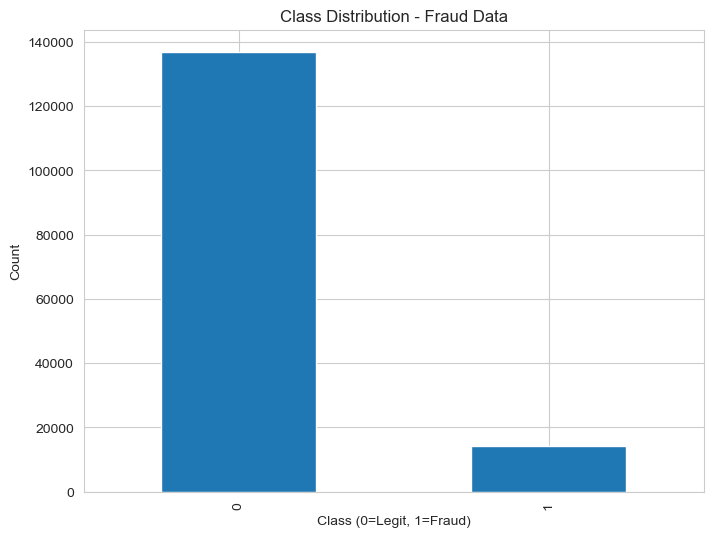

In [15]:
plt.figure(figsize=(8, 6))
fraud_df['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution - Fraud Data')
plt.xlabel('Class (0=Legit, 1=Fraud)')
plt.ylabel('Count')
from pathlib import Path

output_path = Path("../outputs/eda")
output_path.mkdir(parents=True, exist_ok=True)

plt.savefig(output_path / "fraud_class_distribution.png", dpi=300)
plt.show()

Print class distribution

In [5]:
print("\nClass Distribution:")
print(fraud_df['class'].value_counts())
print(f"Fraud Rate: {fraud_df['class'].mean():.4f}")


Class Distribution:
class
0    136961
1     14151
Name: count, dtype: int64
Fraud Rate: 0.0936


Time-based analysis

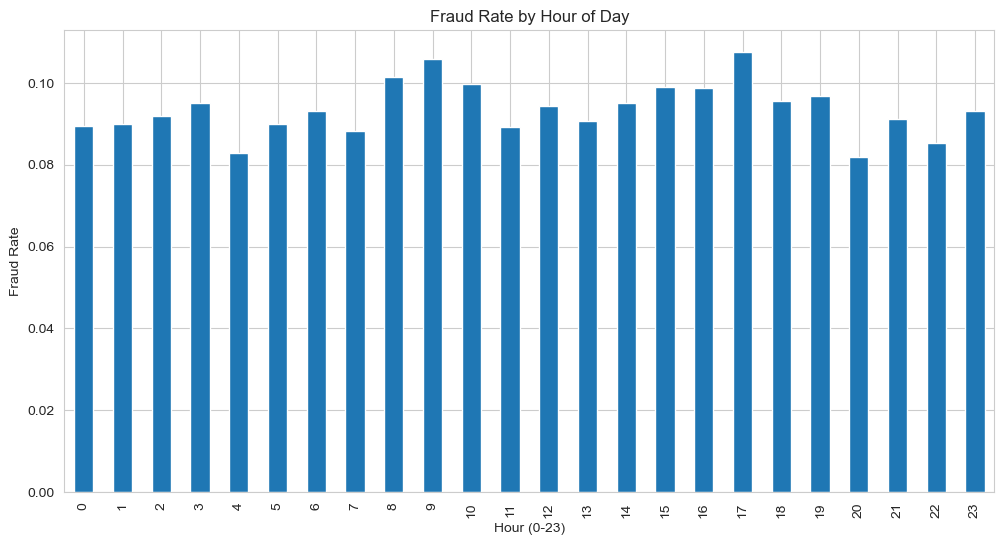

<Figure size 1200x800 with 0 Axes>

In [16]:
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour

plt.figure(figsize=(12, 6))
fraud_df.groupby('hour_of_day')['class'].mean().plot(kind='bar')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Fraud Rate')
plt.show()

from pathlib import Path

output_path = Path("../outputs/eda")
output_path.mkdir(parents=True, exist_ok=True)

plt.savefig(output_path / "fraud_rate_by_hour.png", dpi=300)


Purchase value analysis

2025-12-19 02:41:24,692 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-19 02:41:24,895 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


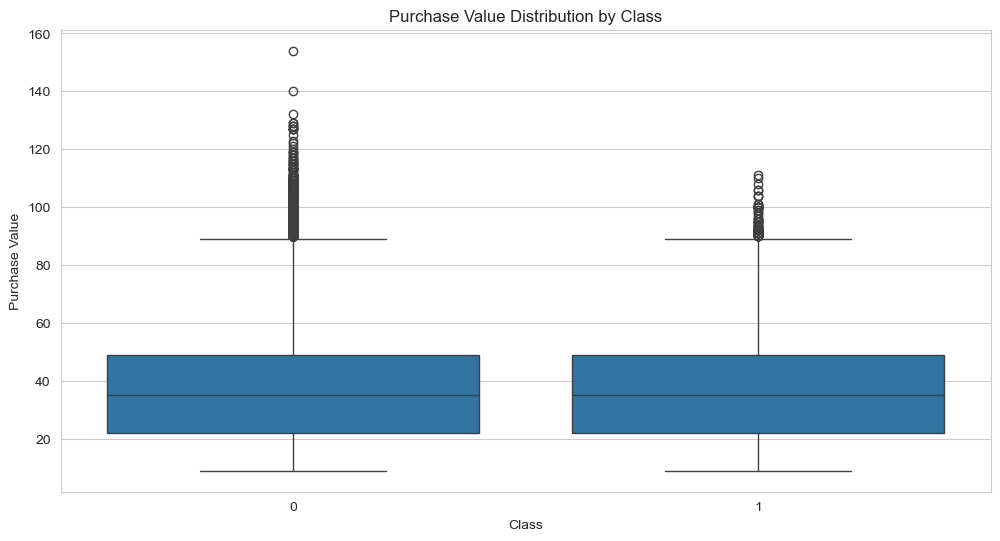

<Figure size 1200x800 with 0 Axes>

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Purchase Value')
plt.show()

from pathlib import Path

output_path = Path("../outputs/eda")
output_path.mkdir(parents=True, exist_ok=True)

plt.savefig(output_path / "purchase_value_by_class.png", dpi=300)


Age distribution

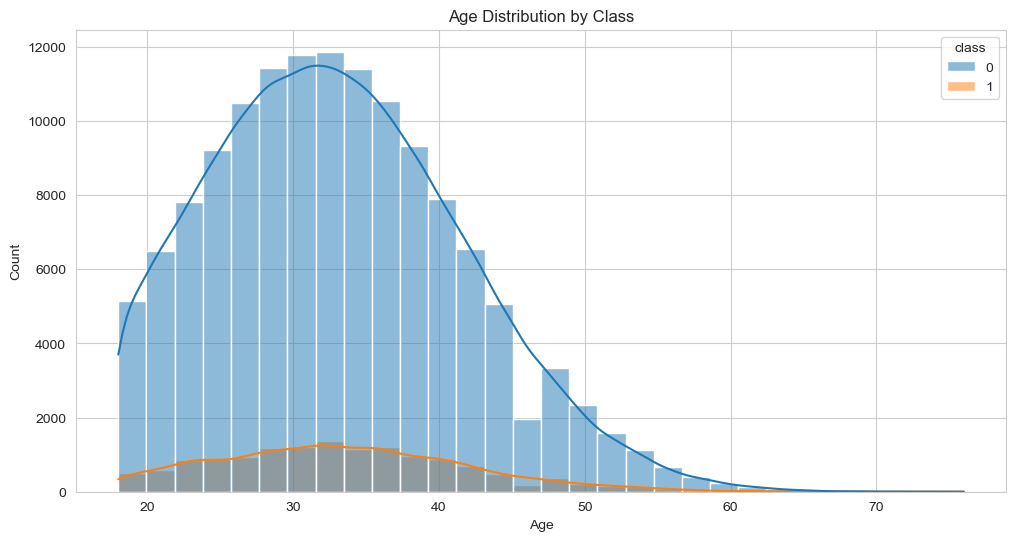

<Figure size 1200x800 with 0 Axes>

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(data=fraud_df, x='age', hue='class', bins=30, kde=True)
plt.title('Age Distribution by Class')
plt.xlabel('Age')
plt.show()

from pathlib import Path

output_path = Path("../outputs/eda")
output_path.mkdir(parents=True, exist_ok=True)

plt.savefig(output_path / "age_distribution.png", dpi=300)


Country analysis (after IP merge)

=== Top 10 Countries by Fraud Rate (min 10 transactions) ===
Empty DataFrame
Columns: [total_transactions, fraud_cases, fraud_rate, unique_ips]
Index: []


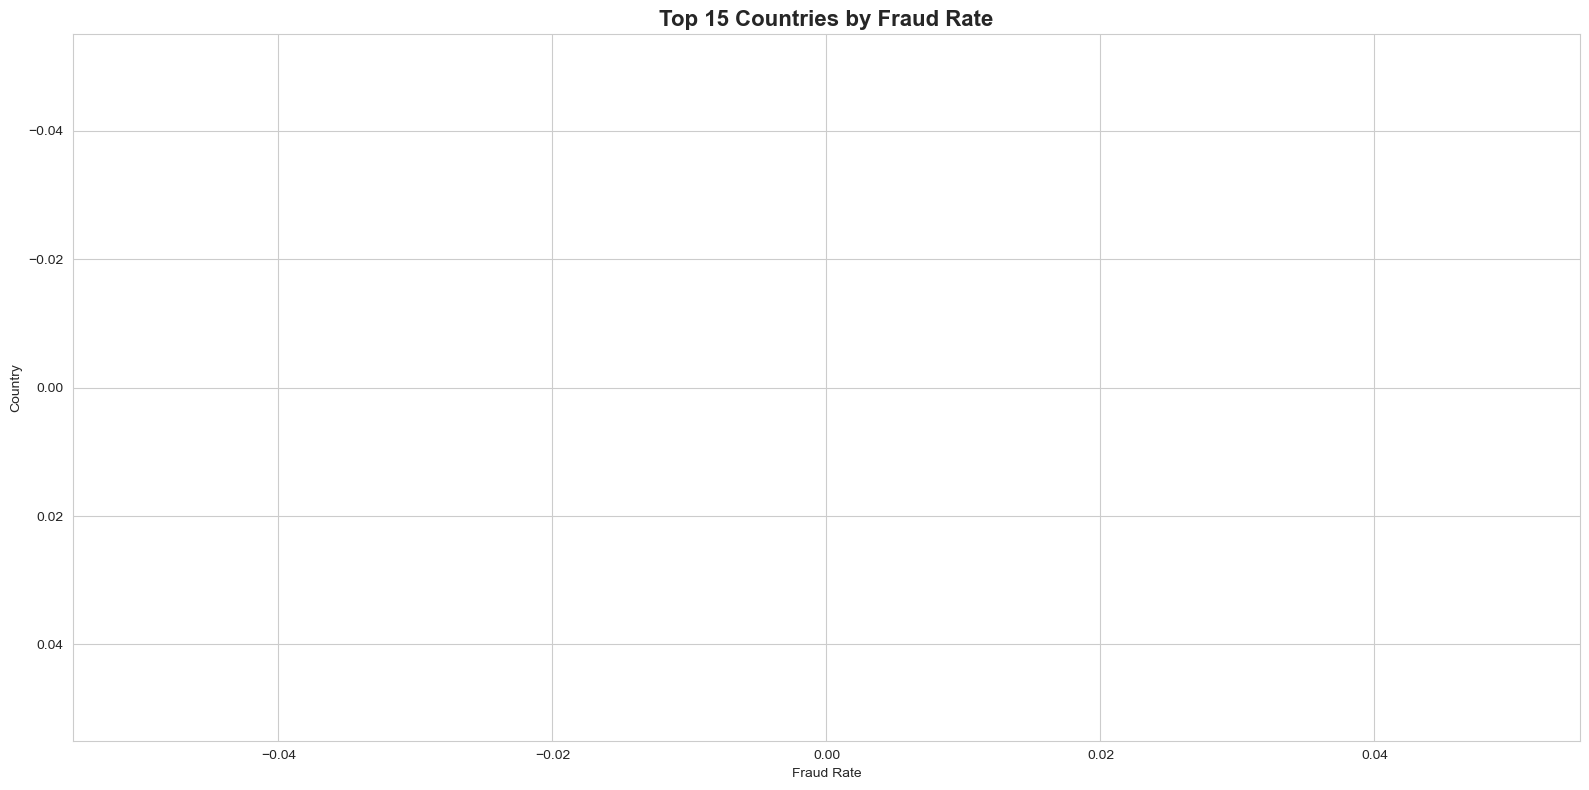

In [21]:
# Calculate fraud rates by country
country_stats = fraud_with_country.groupby('country').agg({
    'class': ['count', 'sum', 'mean'],
    'ip_address': 'nunique'
}).round(4)

country_stats.columns = ['total_transactions', 'fraud_cases', 'fraud_rate', 'unique_ips']
country_stats = country_stats[country_stats['total_transactions'] >= 10]  # Min threshold
country_stats = country_stats.sort_values('fraud_rate', ascending=False)

print("=== Top 10 Countries by Fraud Rate (min 10 transactions) ===")
print(country_stats.head(10))

# Visualize
plt.figure(figsize=(16, 8))
top_countries = country_stats.head(15)

# Create horizontal bar plot with color gradient
bars = plt.barh(top_countries.index, top_countries['fraud_rate'], 
                color=plt.cm.Reds(top_countries['fraud_rate'] / top_countries['fraud_rate'].max()))

plt.title('Top 15 Countries by Fraud Rate', fontsize=16, fontweight='bold')
plt.xlabel('Fraud Rate')
plt.ylabel('Country')
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(top_countries['fraud_rate']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/eda/country_fraud_rates.png', dpi=300, bbox_inches='tight')
plt.show()

Purchase Value Analysis by Percentiles

=== Purchase Value Percentiles ===
    0th percentile: $9.00
   10th percentile: $15.00
   25th percentile: $22.00
   50th percentile: $35.00
   75th percentile: $49.00
   90th percentile: $62.00
   95th percentile: $70.00
   99th percentile: $87.00
  100th percentile: $154.00


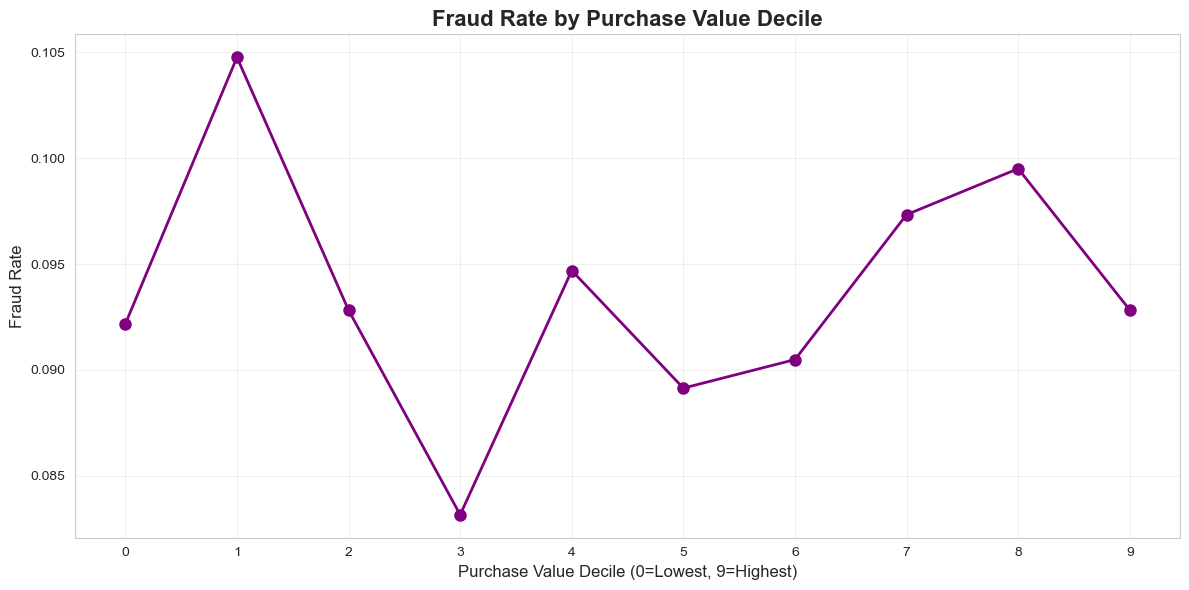

In [23]:
percentiles = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
purchase_percentiles = fraud_df['purchase_value'].quantile(percentiles)

print("=== Purchase Value Percentiles ===")
for p, val in zip(percentiles, purchase_percentiles):
    print(f"{p*100:5.0f}th percentile: ${val:.2f}")

# Fraud rate by purchase value bins
fraud_df['purchase_bin'] = pd.qcut(fraud_df['purchase_value'], q=10, labels=False)

bin_fraud_rate = fraud_df.groupby('purchase_bin')['class'].mean()

plt.figure(figsize=(12, 6))
plt.plot(range(10), bin_fraud_rate, marker='o', linewidth=2, markersize=8, color='purple')
plt.title('Fraud Rate by Purchase Value Decile', fontsize=16, fontweight='bold')
plt.xlabel('Purchase Value Decile (0=Lowest, 9=Highest)', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(10))
plt.tight_layout()
plt.savefig('../outputs/eda/purchase_value_deciles.png', dpi=300, bbox_inches='tight')
plt.show()